https://www.kaggle.com/c/quora-question-pairs


In [1]:
import os, sys, string
import re
import time
import itertools

import tensorflow as tf
import nltk 
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.manifold import TSNE

from collections import Counter


from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.probability import FreqDist

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


import pprint
pp = pprint.PrettyPrinter(indent=4)
#import tflearn

from pivottablejs import pivot_ui

%load_ext watermark

%watermark -u -n -t -z -v -m -p tensorflow,pandas,scipy,numpy,plotly 

last updated: Wed Jul 26 2017 00:09:14 China Standard Time

CPython 3.5.3
IPython 6.1.0

tensorflow 1.2.1
pandas 0.20.1
scipy 0.19.0
numpy 1.13.1
plotly 2.0.9

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 8.1
machine    : AMD64
processor  : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
# https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

# enable output for each command lines. By default, IPython only show ouput for the last command in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read Training Data

In [3]:
# Plotly imports.
# import plotly.offline as plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


import plotly.figure_factory as ff

import plotly.graph_objs as go
#from plotly.graph_objs import *

init_notebook_mode(connected= True)

In [4]:
df = pd.read_csv("./data/train.csv", encoding='utf-8').fillna("")

In [5]:
df.head()
df.tail()
df.info()
df.shape
df.describe()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


(404290, 6)

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%


,qid,question
0,1,What is the step by step guide to invest in sh...
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,5,How can I increase the speed of my internet co...
3,7,Why am I mentally very lonely? How can I solve...
4,9,"Which one dissolve in water quikly sugar, salt..."
5,11,Astrology: I am a Capricorn Sun Cap moon and c...
6,13,Should I buy tiago?
7,15,How can I be a good geologist?
8,17,When do you use シ instead of し?
9,19,Motorola (company): Can I hack my Charter Moto...


,qid,question
0,1,What is the step by step guide to invest in sh...
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,5,How can I increase the speed of my internet co...
3,7,Why am I mentally very lonely? How can I solve...
4,9,"Which one dissolve in water quikly sugar, salt..."


,qid,question
808575,379845,How many keywords are there in PERL Programmin...
808576,155606,Is it true that there is life after death?
808577,537929,What's this coin?
808578,537931,I am having little hairfall problem but I want...
808579,537933,What is it like to have sex with your cousin?


Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780


(array([  5.21491000e+05,   9.55300000e+03,   2.93000000e+03,
          1.44500000e+03,   7.90000000e+02,   5.32000000e+02,
          3.70000000e+02,   2.68000000e+02,   2.03000000e+02,
          1.01000000e+02,   7.70000000e+01,   3.50000000e+01,
          3.50000000e+01,   3.30000000e+01,   2.10000000e+01,
          1.70000000e+01,   1.50000000e+01,   6.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

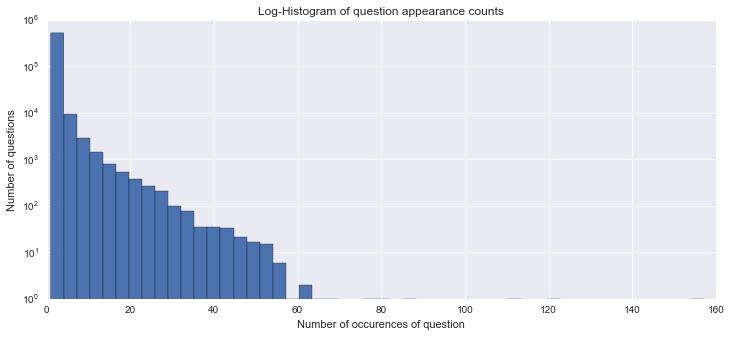

In [7]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

df1 = df[['qid1','question1']]
df2 = df[['qid2','question2']]

df1.columns = ['qid', 'question']
df2.columns = ['qid', 'question']

df_qids = pd.concat([df1, df2], axis =0, ignore_index = True) 
df_qids.reset_index(drop=True)
df_qids.head()
df_qids.tail()


print('Total number of questions in the training data: {}'.format(len(
    np.unique(df_qids.qid))))
print('Number of questions that appear multiple times: {}'.format(np.sum(df_qids.qid.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(df_qids.qid.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

#### Duplicated Questions

In this dataset, each observation has two questions, with unique "qid". After examining the dataset, it appears that some qids appeared more than once in this dataset. The most frequent qid, 2559, appears 157 times in this dataset.



In [8]:
df_ = df_qids.drop_duplicates('qid', keep='first') 
df_.head()
print(df_.question[df_.qid == 2559].iloc[0]) # print the duplicated question

,qid,question
0,1,What is the step by step guide to invest in sh...
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,5,How can I increase the speed of my internet co...
3,7,Why am I mentally very lonely? How can I solve...
4,9,"Which one dissolve in water quikly sugar, salt..."


What are the best ways to lose weight?


In [9]:
df_qids_cnt = df_qids.qid #.apply(str)
df_qids_cnt.dtypes
qids_count = Counter(df_qids_cnt)
qids_id, qid_count = zip(*qids_count.most_common(200))
#qids_id = list(map(str, qids_id))

data = [go.Bar(x=[i for i in range(len(qids_id))], 
               y=list(qid_count), 
               text = ["qid {}: {}".format(q_id, df_.question[df_.qid == q_id].iloc[0] ) for q_id in qids_id ],
               name='Counts')]
#data
iplot(data)

dtype('int64')

## Feature Extraction

### 1. TF-IDF

In [10]:
# X_train_q1, X_train_q2 = X_train[['id','qid1', 'question1']], X_train[['id','qid2', 'question2']]
# X_train_q1.columns = ['id','qid1', 'question']
# X_train_q2.columns = ['id','qid2', 'question']

# # merge two two dfs, there are two nans for question
# X_train_q = pd.concat((X_train_q1, X_train_q2), axis=0).fillna("")
# nrows_for_q1 = X_train_q2.shape[0]/2
# X_train_q2.shape
# nrows_for_q1

In [11]:
# mq1 = TfidfVectorizer(max_features = 256).fit_transform(X_train_q['question'].values)
# mq1

# diff_encodings = np.abs(mq1[::2] - mq1[1::2])
# diff_encodings

## Word Tokenizer and Word Share

In [12]:
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))

# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=False, rm_punc = False, rm_stop_words = True):
    word = word.lower()
    if rm_punc == True and word in set(string.punctuation):
        return None
    
    if rm_stop_words == True and word in stopwords.words('english'):
        return None
    
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
        
    if (wordset == None) or (word in wordset): return word
    else: return "<unk>" # unknown token

stemmer = SnowballStemmer("english")    
def count_words(row, col, start_token = False, stemming = False):
    s = row[col]
    if start_token == False:
        tokens = [word_tokenize(t) for t in sent_tokenize(s)]
    else:
        tokens = (["<s>"] + word_tokenize(t) + ["</s>"] for t in sent_tokenize(s)) # generator expression
    #return [canonicalize_word(w) for w in flatten(tokens)]    
    words = []

    for w in flatten(tokens):
        w_ = canonicalize_word(w)
        if w_ != None and stemming:
                w_ = stemmer.stem(w_)
        
        words.append(w_)
    return words
           
def word_share(row, col1, col2):
    word_set1 = set(row[col1])
    word_set2 = set(row[col2])
    return 1.0 * len(word_set1 & word_set2)/(len(word_set1) + len(word_set2))

    return 1.0 * len(word_set1 & word_set2)/(len(word_set1) + len(word_set2))


In [13]:
df['words1'] = df.apply(count_words, axis=1, col = 'question1')
df['words2'] = df.apply(count_words, axis=1, col = 'question2')

df['q1_n_words'] = df['words1'].apply(lambda words: len(words))
df['q2_n_words'] = df['words2'].apply(lambda words: len(words))

df['words_share'] = df.apply(word_share, axis=1, col1 = 'words1', col2 = 'words2')

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,words1,words2,q1_n_words,q2_n_words,words_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[None, None, None, step, None, step, guide, No...","[None, None, None, step, None, step, guide, No...",15,13,0.466667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[None, None, None, story, None, kohinoor, (, k...","[None, would, happen, None, None, indian, gove...",11,16,0.333333
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[None, None, None, increase, None, speed, None...","[None, None, internet, speed, None, increased,...",15,11,0.266667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[None, None, None, mentally, None, lonely, ?, ...","[find, None, remainder, None, [, math, ], 23^,...",13,19,0.105263
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[None, one, dissolve, None, water, quikly, sug...","[None, fish, would, survive, None, salt, water...",16,8,0.200000


In [14]:
X = df
Y = df[['id','is_duplicate']]

# leave out 20% for test set set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=42)

X_train
Y_train

X_test
Y_test

,id,qid1,qid2,question1,question2,is_duplicate,words1,words2,q1_n_words,q2_n_words,words_share
352886,352886,214777,481858,What are some of the short stories?,What are some great short stories with a twist...,0,"[None, None, None, None, None, short, stories, ?]","[None, None, None, great, short, stories, None...",8,11,0.363636
134949,134949,178460,215604,Is this a German Shepherd dog?,Are german shepherd dogs loyal?,0,"[None, None, None, german, shepherd, dog, ?]","[None, german, shepherd, dogs, loyal, ?]",7,6,0.363636
168419,168419,74366,106454,What is the most important lesson ever learned...,What are the most important lessons you have l...,1,"[None, None, None, None, important, lesson, ev...","[None, None, None, None, important, lessons, N...",12,19,0.357143
402543,402543,257727,111990,Which ad networks for mobile native ads have a...,Which ad networks for desktop native ads have ...,1,"[None, ad, networks, None, mobile, native, ads...","[None, ad, networks, None, desktop, native, ad...",16,16,0.458333
13551,13551,26006,26007,What should I do to be an athlete in a month?,What is shop act licence?,0,"[None, None, None, None, None, None, None, ath...","[None, None, shop, act, licence, ?]",12,6,0.222222
98507,98507,163682,163683,How long can earth sustain humanity?,How long will it be before the earth will not ...,1,"[None, long, None, earth, sustain, humanity, ?]","[None, long, None, None, None, None, None, ear...",7,18,0.357143
114293,114293,82655,186597,How to start preparing for UPSC 2018?,How and when should I start my preparations fo...,1,"[None, None, start, preparing, None, upsc, 201...","[None, None, None, None, None, start, None, pr...",8,12,0.416667
184067,184067,151317,281317,Do developers NEED to upgrade from Swift 2 to ...,Should I read all of Swift 2?,0,"[None, developers, need, None, upgrade, None, ...","[None, None, read, None, None, swift, 2, ?]",12,8,0.307692
27138,27138,50438,16792,What is a zip code?,How do you find out what your zip code plus fo...,0,"[None, None, None, zip, code, ?]","[None, None, None, find, None, None, None, zip...",6,13,0.363636
199544,199544,173735,301068,Which job searching sites exist for Germany?,What is a good website for searching jobs in G...,1,"[None, job, searching, sites, exist, None, ger...","[None, None, None, good, website, None, search...",8,11,0.285714


,id,is_duplicate
352886,352886,0
134949,134949,0
168419,168419,1
402543,402543,1
13551,13551,0
98507,98507,1
114293,114293,1
184067,184067,0
27138,27138,0
199544,199544,1


,id,qid1,qid2,question1,question2,is_duplicate,words1,words2,q1_n_words,q2_n_words,words_share
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,"[None, None, None, play, pokémon, go, None, ko...","[None, None, None, play, pokémon, go, None, ch...",9,9,0.416667
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,"[None, None, None, None, None, best, side, dis...","[None, None, None, good, side, dishes, None, b...",12,10,0.285714
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,"[None, None, None, advisable, None, better, ma...","[None, None, None, best, server, setup, None, ...",18,9,0.117647
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,"[None, None, None, improve, logical, programmi...","[None, None, None, improve, None, logical, ski...",8,10,0.500000
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,"[None, close, None, None, None, see, 3rd, worl...","[None, close, None, None, world, war, iii, ?]",10,8,0.384615
215105,215105,177688,83888,What do Chinese people think about Donald Trump?,What do Chinese people think of Donald Trump?,1,"[None, None, chinese, people, think, None, don...","[None, None, chinese, people, think, None, don...",9,9,0.500000
253209,253209,367707,153452,How many hours a week do Google employees work?,How many hours a day do Google employees work ...,0,"[None, many, hours, None, week, None, google, ...","[None, many, hours, None, day, None, google, e...",10,12,0.411765
354651,354651,483796,11244,How can we follow a Quora question privately w...,How can we view private Instagram pictures wit...,0,"[None, None, None, follow, None, quora, questi...","[None, None, None, view, private, instagram, p...",15,11,0.166667
104478,104478,172497,172498,Why are cats so overprotective?,How do you know if your cat is overprotective?,1,"[None, None, cats, None, overprotective, ?]","[None, None, None, know, None, None, cat, None...",6,10,0.333333
163628,163628,254474,254475,How do I improve logical programming skills?,What is the best way to improve logical skills...,1,"[None, None, None, improve, logical, programmi...","[None, None, None, best, way, None, improve, l...",8,12,0.428571


,id,is_duplicate
8067,8067,0
368101,368101,0
70497,70497,0
226567,226567,1
73186,73186,1
215105,215105,1
253209,253209,0
354651,354651,0
104478,104478,1
163628,163628,1


In [15]:
X_train_mini = X_train[:5000].copy()


# X_train_mini['words1'] = X_train_mini.apply(count_words, axis=1, col = 'question1')
# X_train_mini['words2'] = X_train_mini.apply(count_words, axis=1, col = 'question2')

# X_train_mini['q1_n_words'] = X_train_mini['words1'].apply(lambda words: len(words))
# X_train_mini['q2_n_words'] = X_train_mini['words2'].apply(lambda words: len(words))

# X_train_mini['words_share'] = X_train_mini.apply(word_share, axis=1, col1 = 'words1', col2 = 'words2')

# X_train_mini.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



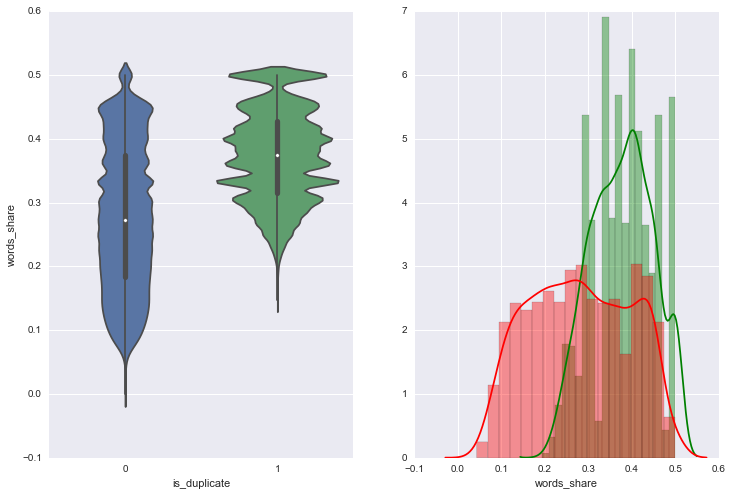

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'words_share', data = X_train)
plt.subplot(1,2,2)
sns.distplot(X_train_mini[X_train['is_duplicate'] == 1.0]['words_share'], color = 'green')
sns.distplot(X_train_mini[X_train['is_duplicate'] == 0.0]['words_share'], color = 'red')

In [17]:
trace = go.Scatter(
    y = X_train_mini['q1_n_words'].values,
    x = X_train_mini['q2_n_words'].values,
    mode='markers',
    marker=dict(
        size= X_train_mini['words_share'].values * 60,
        color = X_train_mini['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(X_train_mini['words_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of word count of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question words count',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')



### 2. Embedding 

In [18]:
from sklearn.preprocessing import MinMaxScaler


X_ = MinMaxScaler().fit_transform(X_train_mini[['q1_n_words', 'q2_n_words', 'words_share']])
Y_ = X_train_mini['is_duplicate'].values

In [19]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(X_)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.017074
[t-SNE] Iteration 25: error = 1.8484204, gradient norm = 0.0059232
[t-SNE] Iteration 50: error = 1.7694976, gradient norm = 0.0042610
[t-SNE] Iteration 75: error = 1.4389319, gradient norm = 0.0016147
[t-SNE] Iteration 100: error = 1.3723027, gradient norm = 0.0014601
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.372303
[t-SNE] Iteration 125: error = 1.2563441, gradient norm = 0.0017289
[t-SNE] Iteration 150: error = 1.2158715, gradient norm = 0.0015995
[t-SNE] Iteration 175: error = 1.2060446, gradient norm = 0.0017812
[t-SNE] I

In [20]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = Y_,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.50
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## Model 

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

# split the Train test into Train and Dev 
# X_train_, X_dev_, Y_train_, Y_dev_ = model_selection.train_test_split(
#                 X_train[['q1_n_words', 'q2_n_words', 'words_share']], 
#                 Y_train['is_duplicate'], 
#                 test_size=0.25, 
#                 random_state=777)


X_ = MinMaxScaler().fit_transform(X_train[['q1_n_words', 'q2_n_words', 'words_share']])
Y_ = Y_train['is_duplicate']

#X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])


X_train_, X_dev_, Y_train_, Y_dev_ = train_test_split(X_, Y_, test_size=0.25, random_state=777)

X_train_.shape, X_dev_.shape, Y_train_.shape, Y_dev_.shape

X_train_
Y_train_
X_dev_
Y_dev_



((242574, 3), (80858, 3), (242574,), (80858,))

array([[ 0.07692308,  0.07352941,  0.66666667],
       [ 0.04895105,  0.04044118,  0.76923077],
       [ 0.11188811,  0.05882353,  0.54545455],
       ..., 
       [ 0.05594406,  0.03676471,  1.        ],
       [ 0.06293706,  0.03676471,  0.76923077],
       [ 0.06293706,  0.02941176,  0.8       ]])

272995    1
335947    1
70495     1
58942     0
51237     1
180428    0
233122    1
378545    0
386839    0
309056    0
224810    0
309335    1
36381     1
380222    1
398263    0
340360    1
399790    1
7371      0
348971    0
402854    1
93922     0
373489    0
70423     0
292733    0
390272    1
103695    0
339350    0
209068    0
288724    0
251710    0
         ..
403340    0
194275    0
343092    1
139832    1
201654    0
349505    0
391680    0
172111    0
379874    1
248701    1
225939    0
34886     0
303657    1
262428    0
292309    0
305244    1
289796    0
160830    0
211787    0
50002     0
152628    1
253057    0
364968    0
317412    0
385301    0
108568    1
100771    0
303536    1
40576     1
19892     1
Name: is_duplicate, Length: 242574, dtype: int64

array([[ 0.13286713,  0.03308824,  0.92307692],
       [ 0.07692308,  0.04779412,  0.875     ],
       [ 0.06293706,  0.03308824,  0.90909091],
       ..., 
       [ 0.06993007,  0.06617647,  0.19047619],
       [ 0.04895105,  0.02205882,  0.85714286],
       [ 0.04195804,  0.02941176,  0.72727273]])

236389    1
1272      1
396938    0
175165    0
54579     0
136951    0
242126    1
279097    0
13256     1
62670     1
262233    1
164988    0
5043      0
177188    0
377389    1
112931    1
244929    0
311044    0
199954    1
210693    1
327629    1
271011    1
100302    0
104836    0
7978      1
240754    0
182913    1
217589    0
190124    0
77916     0
         ..
219622    1
327159    0
297684    1
114341    0
393399    0
128332    0
66159     0
361234    0
361400    1
206244    0
372615    1
11712     0
364286    0
349990    1
137575    0
30364     0
341103    1
312497    0
18091     0
292122    1
341647    1
107666    1
237600    0
349894    0
70977     1
154890    0
157145    0
247159    0
372652    0
284788    1
Name: is_duplicate, Length: 80858, dtype: int64

In [22]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train_, Y_train_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   29.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-06, 0.001, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

In [23]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

6. Mean validation neg log loss: -0.693 (std: 0.000) - {'penalty': 'l1', 'C': 1e-06}
5. Mean validation neg log loss: -0.690 (std: 0.000) - {'penalty': 'l2', 'C': 1e-06}
3. Mean validation neg log loss: -0.564 (std: 0.000) - {'penalty': 'l1', 'C': 0.001}
4. Mean validation neg log loss: -0.584 (std: 0.000) - {'penalty': 'l2', 'C': 0.001}
1. Mean validation neg log loss: -0.557 (std: 0.000) - {'penalty': 'l1', 'C': 1.0}
2. Mean validation neg log loss: -0.557 (std: 0.000) - {'penalty': 'l2', 'C': 1.0}


In [24]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'penalty': 'l1', 'C': 1.0}
[[-0.17826406 -2.3425478   4.85650966]]


#### ROC


LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C: 1e-06, parameters [[-0.00319942 -0.00190442 -0.00760861]] and intercept [-0.02972533]


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

C: 0.0001, parameters [[-0.12728627 -0.07793536  0.50521771]] and intercept [-0.71679293]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

C: 1.0, parameters [[-0.23300695 -2.20403978  4.85499754]] and intercept [-3.62269715]


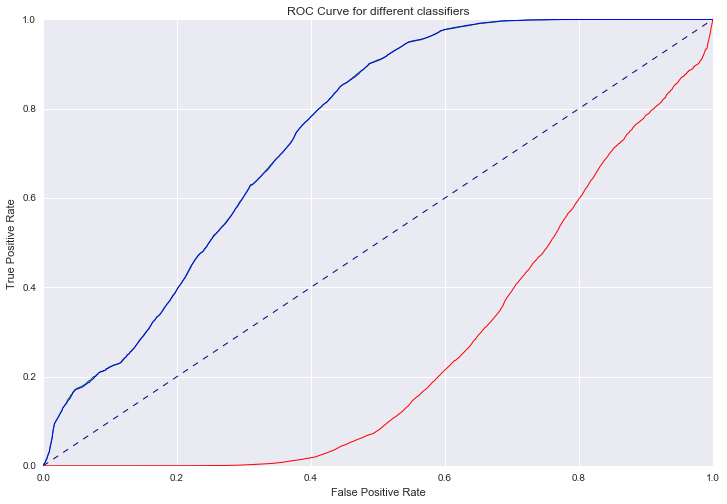

In [25]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train_, Y_train_)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(Y_dev_, clf.predict_proba(X_dev_)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))


### Precision-Recall Curve


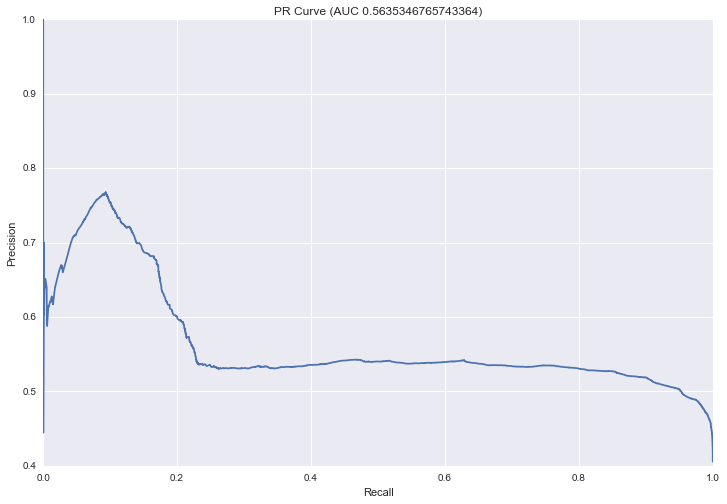

In [26]:
pr, re, _ = precision_recall_curve(Y_dev_, cv.best_estimator_.predict_proba(X_dev_)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')